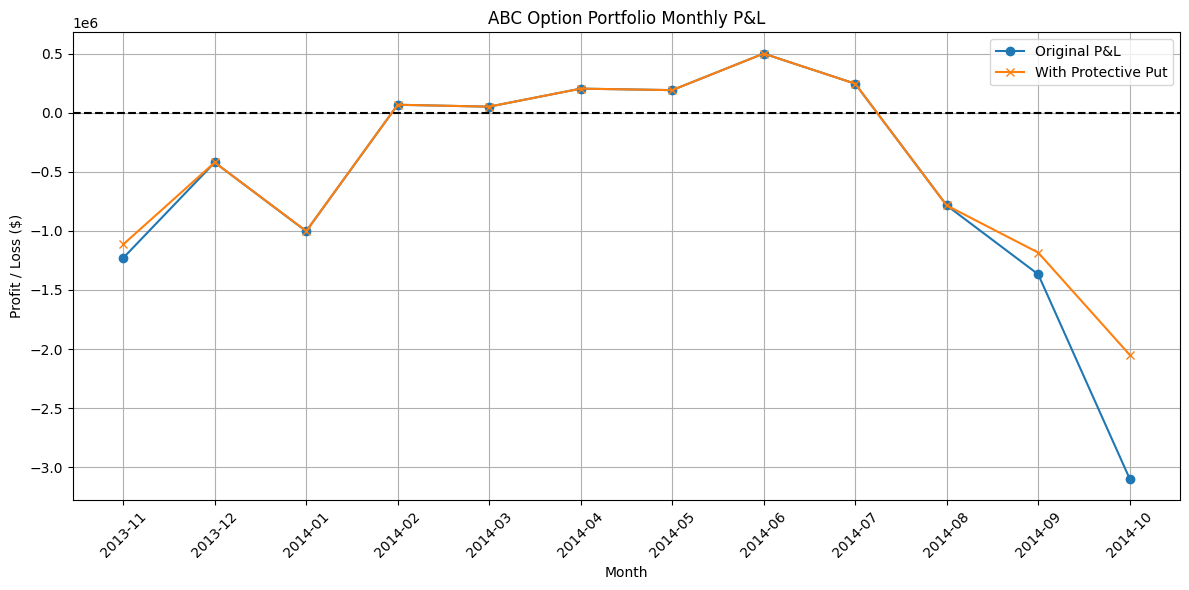

,Month,Avg_WTI,Long_Call,Short_Call,Short_Put,Total_per_bbl,Monthly_PnL,Protective_Put,Adjusted_per_bbl,Adjusted_PnL,Cumulative_PnL,Cumulative_Adjusted_PnL
0,2013-11,93.852857,0.000000,0.000000,-12.294286,-12.294286,-1.229429e+06,1.147143,-11.147143,-1.114714e+06,-12.294286,-11.147143
1,2013-12,97.894286,0.000000,0.000000,-4.211429,-4.211429,-4.211429e+05,0.000000,-4.211429,-4.211429e+05,-16.505714,-15.358571
2,2014-01,94.983478,0.000000,0.000000,-10.033043,-10.033043,-1.003304e+06,0.016522,-10.016522,-1.001652e+06,-26.538758,-25.375093
3,2014-02,100.670500,0.670500,0.000000,0.000000,0.670500,6.705000e+04,0.000000,0.670500,6.705000e+04,-25.868258,-24.704593
4,2014-03,100.509048,0.509048,0.000000,0.000000,0.509048,5.090476e+04,0.000000,0.509048,5.090476e+04,-25.359210,-24.195546
5,2014-04,102.034762,2.034762,0.000000,0.000000,2.034762,2.034762e+05,0.000000,2.034762,2.034762e+05,-23.324448,-22.160784
6,2014-05,101.907727,1.907727,0.000000,0.000000,1.907727,1.907727e+05,0.000000,1.907727,1.907727e+05,-21.416721,-20.253056
7,2014-06,105.146667,5.146667,-0.146667,0.000000,5.000000,5.000000e+05,0.000000,5.000000,5.000000e+05,-16.416721,-15.253056
8,2014-07,102.451304,2.451304,0.000000,0.000000,2.451304,2.451304e+05,0.000000,2.451304,2.451304e+05,-13.965417,-12.801752
9,2014-08,96.076190,0.000000,0.000000,-7.847619,-7.847619,-7.847619e+05,0.000000,-7.847619,-7.847619e+05,-21.813036,-20.649371


In [25]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load WTI crude oil futures data from Excel (replace with your filename)
wti = pd.read_excel('/Users/janithsanthush/Desktop/WTI historical data.xlsx')

# Step 2: Prepare the data
wti['Date'] = pd.to_datetime(wti['Date'])
wti.set_index('Date', inplace=True)
wti = wti[['Price']].rename(columns={'Price': 'WTI_Price'})
wti.dropna(inplace=True)

# Step 3: Filter the data by the required date range
start_date = '2013-11-01'
end_date = '2014-10-31'
wti = wti[(wti.index >= start_date) & (wti.index <= end_date)]

# Step 4: Monthly average prices
wti['Month'] = wti.index.to_period('M')
monthly_avg = wti.groupby('Month')['WTI_Price'].mean().reset_index()
monthly_avg.columns = ['Month', 'Avg_WTI']

# Step 3: Option Portfolio Parameters
strike_call1 = 100
strike_call2 = 105
strike_put = 100
quantity = 100000  # barrels

# Step 4: Calculate Payoffs
monthly_avg['Long_Call'] = monthly_avg['Avg_WTI'].apply(lambda x: max(x - strike_call1, 0))
monthly_avg['Short_Call'] = monthly_avg['Avg_WTI'].apply(lambda x: -max(x - strike_call2, 0))
monthly_avg['Short_Put'] = monthly_avg['Avg_WTI'].apply(lambda x: -2 * max(strike_put - x, 0))

monthly_avg['Total_per_bbl'] = (
    monthly_avg['Long_Call'] +
    monthly_avg['Short_Call'] +
    monthly_avg['Short_Put']
)
monthly_avg['Monthly_PnL'] = monthly_avg['Total_per_bbl'] * 100000 

# Step 5: Add Protective Put Strategy
protective_put_strike = 95

monthly_avg['Protective_Put'] = monthly_avg['Avg_WTI'].apply(lambda x: max(protective_put_strike - x, 0))
monthly_avg['Adjusted_per_bbl'] = monthly_avg['Total_per_bbl'] + monthly_avg['Protective_Put'] 
monthly_avg['Adjusted_PnL'] = monthly_avg['Adjusted_per_bbl'] * quantity

# Step 6: Track cumulative P&L and check if termination condition is hit
monthly_avg['Cumulative_PnL'] = monthly_avg['Total_per_bbl'].cumsum()
monthly_avg['Cumulative_Adjusted_PnL'] = monthly_avg['Adjusted_per_bbl'].cumsum()

# Step 7: Prepare payoff diagram
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['Month'].astype(str), monthly_avg['Monthly_PnL'], label='Original P&L', marker='o')
plt.plot(monthly_avg['Month'].astype(str), monthly_avg['Adjusted_PnL'], label='With Protective Put', marker='x')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Profit / Loss ($)')
plt.title("ABC Option Portfolio Monthly P&L")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output the monthly_avg DataFrame for review
monthly_avg[['Month', 'Avg_WTI','Long_Call','Short_Call','Short_Put', 'Total_per_bbl','Monthly_PnL','Protective_Put', 'Adjusted_per_bbl','Adjusted_PnL','Cumulative_PnL','Cumulative_Adjusted_PnL']]


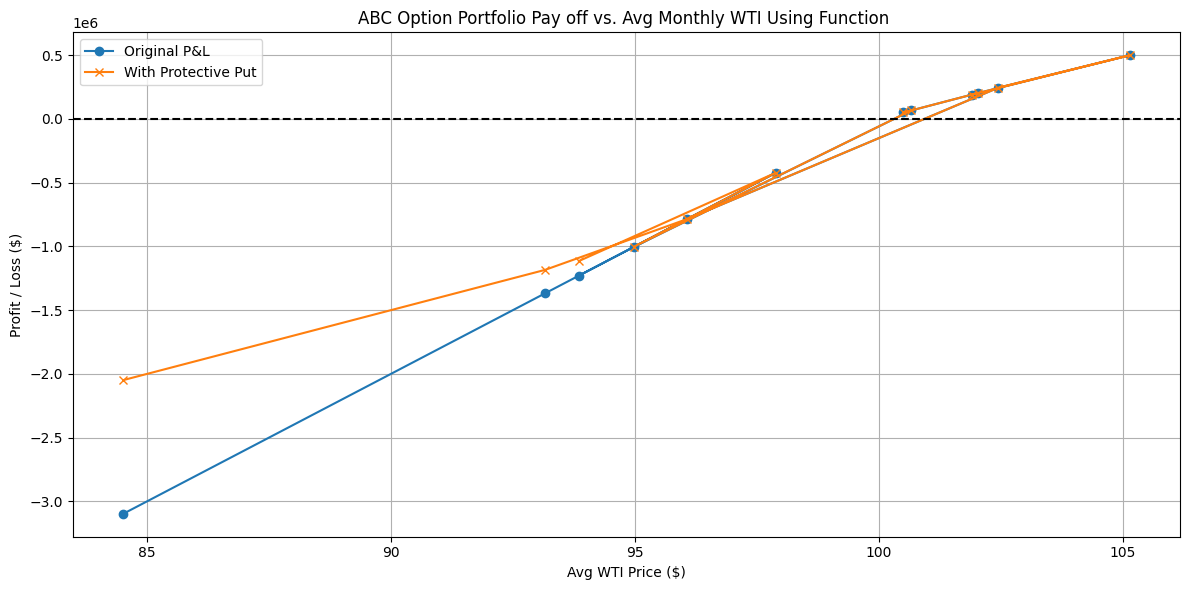

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['Avg_WTI'], monthly_avg['Monthly_PnL'], label='Original P&L', marker='o')
plt.plot(monthly_avg['Avg_WTI'], monthly_avg['Adjusted_PnL'], label='With Protective Put', marker='x')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Avg WTI Price ($)')
plt.ylabel('Profit / Loss ($)')
plt.title("ABC Option Portfolio Pay off vs. Avg Monthly WTI Using Function ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()